# Facebook Prophet Notebook

## Description:

This notebook aims to implement **Prophet Model** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **Prophet Model** are capable of forecasting both stationary and non stationary series.

## Notebook Details:

This notebook is divided into 2 main parts: Stationary Series (were differentiated) and Non-stationary Series (original series)

The purpose of crating those parts is to compare with the ARIMA results, that need the series to be stationary.

Each of the parts is divided into subparts as follows:
 - Importing data and transforming
 - Splitting Train and Test Data
 - Hyperparamter search
 - Training Models with the best hyperparameters
 - Comparing the fitted models with the original series
 - Testing and comparing the models with 1 step forecast
 - Testing and comparing the models with 12 step forecast

## Prophet (not so) Brief Introduction

The Prophet is a Facebook Open Source project for time series predictions based on an additive model that tries to sum together 3 different functions that tries to model trend $g(t)$, seasonality $s(t)$ and holiday/weekend effects $h(t)$.

$$
y(t)=g(t)+s(t)+h(t)+\epsilon_t
$$
	
The Trend model, $g(t)$, can be implemented in two different ways. First, there is a model that assumes a linear growth over time without a saturation point. Secondly, there is a non linear growth with a carrying capacity as saturation point. The equations that define these models are, respectively:

$$
g(t)=(k+a(t)^T\delta)t+(m+a(t)^T\gamma)

g(t)=\dfrac{C}{1+exp(-k(t-m))}
$$

where $k$ is the growth rate, $\delta$ has the rate adjustment, $m$ is the offset parameter, $\gamma$ is a variable to make the function continuous and $C$ is the carrying capacity.

The seasonality model is, basically, a Fourier Series that captures the periodic behaviour of the seasonal model.

$$
	s(t)=\sum_{n=1}^{N}\left(\alpha_ncos\left(\dfrac{2\pi nt}{P}\right)+\beta_nsin\left(\dfrac{2\pi nt}{P}\right)\right)
$$


At last, the holidays/weekend model is implemented with a auxiliary table that list all the holidays and events. This table is used to add an indicator functions that tells if a time step $t$ occurs during a holiday $i$ and assign a parameter for each holiday which is the corresponding change in the forecast \cite{taylor2018forecasting}. Note that the holiday model is not of large importance for this project since the frequency of the time series is weekly and the table presented above was not implemented.

The following articles, as well as the official webpage of the Prophet Project are extremelly helpfull to, at least, have a good general ideia of the model.

__[Prophet Project Website](https://facebook.github.io/prophet/)__ 

__[Facebook Research Article](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/)__ 

__[Machine Learning Mastery Article](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)__ 

__[Towards Data Science Article](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)__ 



In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection # hyperparameter search
import sklearn.metrics
from fbprophet import Prophet
import itertools

np.random.seed(0)

Importing plotly failed. Interactive plots will not work.


### Some useful functions

In [44]:
#Read and filter data from csv files
#This function is a bit different from the one implemented in the other notebooks, cince the prophet algorithm needs its input organized in a certain way:
#A pandas dataframe with to columns -> ds: date time objects, Y: time series values
#It also does not handle missing values because the prophet model is able to do it
def read_filter(path,index,value):
    df = pd.read_csv(path)
    #getting just the dates columns and the value os interest column (it is goind to be "AdjClose")
    series = df.loc[:,[index,value]]
    #Setting the right colum names and types, as asked by the Prophet
    series.columns = ['ds','y']
    series['ds']= pd.to_datetime(series['ds'])

    return series

#plot two time series
def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=0,y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
    
# differentiate the series
def diff(series,t):

    for i in range(t):
        series.y = series.y - series.y.shift(1)
        series.y = series.y.dropna()

    series = series.drop([0],axis=0)

    return series


#normalize time series values into range [0,1]
def normalize(serie):
    values = serie.y

    _min = np.min(values)
    _max = np.max(values)
    
    norm_values = (values - _min)/(_max - _min)
    
    serie.y = norm_values
    serie = serie.fillna(0)

    return serie


#Function to split the time series into training and test sets
def train_test(serie,split):
    train_serie = serie.drop(serie.index[-12:])
    test_serie = serie.drop(serie.index[0:-12])

    return train_serie,test_serie
    
#Compute some error metrics
def errors(actual, predicted):
    me = np.mean(predicted - actual)  # ME
    mae = sklearn.metrics.median_absolute_error(actual,predicted)    # MAE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual,predicted))  # RMSE
    
    errors = [['ME',me],['MAE',mae],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

#Function that manually search for the best hyperparameters combination with RMSE as metric
def hyperparameter_search(data,all_params):
    #We will use RMSE as the metric to choose the best combination of hyperparameter
    rmses = []  
    orig = data.y
    for params in all_params:
        model = Prophet(**params).fit(data)
        pred = model.predict(data).yhat
        rmses.append(np.sqrt(sklearn.metrics.mean_squared_error(orig,pred)))

    return rmses

#Function that returns the best hyperparameter combination as a dictionary
def select_best_hyperparameters(rmses,all_params):
    min_error = min(rmses)
    ind = rmses.index(min_error)
    return all_params[ind]




### Importing the series and differenciating in order to get stationary behavior

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')


#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

# normalizing the series
USD_CAD_serie_diff1 = normalize(USD_CAD_serie_diff1)
USD_BRL_serie_diff1 = normalize(USD_BRL_serie_diff1)
AmericanAirlines_serie_diff1 = normalize(AmericanAirlines_serie_diff1)


print(AmericanAirlines_serie_diff1.head())
print(USD_CAD_serie_diff1.head())
print(USD_BRL_serie_diff1.head())

          ds         y
1 2010-01-08  0.537584
2 2010-01-15  0.502102
3 2010-01-22  0.488057
4 2010-01-29  0.537584
5 2010-02-05  0.573065
          ds         y
1 2010-01-08  0.287350
2 2010-01-15  0.633599
3 2010-01-22  0.526427
4 2010-01-29  0.438490
5 2010-02-05  0.184758
          ds         y
1 2010-01-08  0.554999
2 2010-01-15  0.569406
3 2010-01-22  0.607617
4 2010-01-29  0.538963
5 2010-02-05  0.487221


## Training and Test Sets

There are 4 important steps that will be/have been done to the time series in order to pass them as input to the MLP.
 - First we differentiate the series in order to obtain a stationary time series. This won't be done in the second part of the notebook. *Done*
 - Then, we should normaize the series values so that they are all between [0,1], since this is machine learning good practice. *Done*
 - We must split our series into training anda test data, as usual. We have set the test data to have length 12 since this is the largest horizon we aim to forecast. We also divide the datasets int o inputs **X** and targets **y**. *Next Cell*

In [4]:
split = 12

american_train, american_test = train_test(AmericanAirlines_serie_diff1,split) 
USD_BRL_train, USD_BRL_test = train_test(USD_BRL_serie_diff1,split) 
USD_CAD_train, USD_CAD_test = train_test(USD_CAD_serie_diff1,split) 

## Implementing Prophet with Hyperparemeter Search

Let's see what each of the hyperparameters mean with both the __[Prophet Guide](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)__ and personal coments:
 - changepoint_prior_scale: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints.
 - seasonality_prior_scale: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. 
 - holidays_prior_scale:This controls flexibility to fit holiday effects. -> this parameter is, actually, useless for us since we don't provide a holiday table
 - seasonality_mode: Options are ['additive', 'multiplicative']. Depends if the magnitude of seasonal fluctuations grows with the magnitude of the time series



In [5]:
#Hyperparameters
changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale = [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

In [6]:
import warnings
warnings.filterwarnings(action='ignore')


param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale,
    'seasonality_prior_scale': seasonality_prior_scale,
    'seasonality_mode': seasonality_mode,
    'holidays_prior_scale': holidays_prior_scale
}

#Since Prophet is not a Sklearn estimator, we will have to code the hyperparameter tunning by hand!
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

#Seaching for the best hyperparameter
rmses_american = hyperparameter_search(american_train,all_params)
rmses_USD_CAD = hyperparameter_search(USD_CAD_train,all_params)
rmses_USD_BRL = hyperparameter_search(USD_BRL_train,all_params)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [7]:
#Getting the best hyperparameter option
best_american = select_best_hyperparameters(rmses_american,all_params)
best_USD_CAD = select_best_hyperparameters(rmses_USD_CAD,all_params)
best_USD_BRL = select_best_hyperparameters(rmses_USD_BRL,all_params)

print("Best Hyperparameters American -> ",best_american)
print("Best Hyperparameters USD_CAD -> ",best_USD_CAD)
print("Best Hyperparameters USD_BRL -> ",best_USD_BRL)

Best Hyperparameters American ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}
Best Hyperparameters USD_CAD ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}
Best Hyperparameters USD_BRL ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


## Training the Prophet with the best hyperparameters

In [8]:
prophet_American = Prophet(changepoint_prior_scale=0.5,
                            seasonality_prior_scale=0.1,
                            holidays_prior_scale=0.01,
                            seasonality_mode='additive').fit(american_train)


prophet_USD_CAD = Prophet(changepoint_prior_scale=0.5,
                            seasonality_prior_scale=10,
                            holidays_prior_scale=0.01,
                            seasonality_mode='additive').fit(USD_CAD_train)

prophet_USD_BRL = Prophet(changepoint_prior_scale=0.5,
                            seasonality_prior_scale=0.1,
                            holidays_prior_scale=0.01,
                            seasonality_mode='multiplicative').fit(USD_BRL_train)                     

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

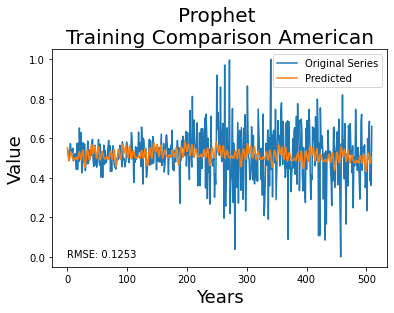

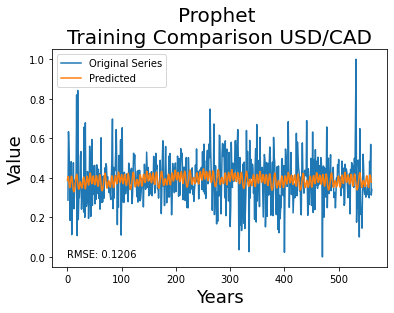

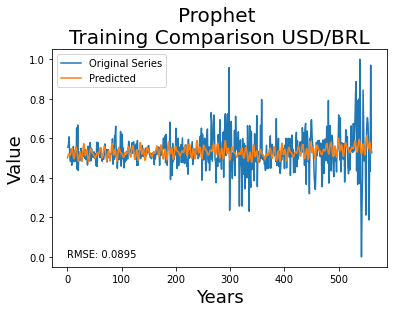


American Model Prediction Errors
  Error     Value
0    ME  0.000210
1   MAE  0.066516
2  RMSE  0.125275

USD/CAD Model Prediction Errors
  Error     Value
0    ME -0.000094
1   MAE  0.073830
2  RMSE  0.120577

USD/BRL Model Prediction Errors
  Error     Value
0    ME  0.000032
1   MAE  0.042295
2  RMSE  0.089500


In [9]:
american_predicted = prophet_American.predict(american_train)
USD_CAD_predicted = prophet_USD_CAD.predict(USD_CAD_train)
USD_BRL_predicted = prophet_USD_BRL.predict(USD_BRL_train)

plot_2_series(real=american_train.y,
            model=american_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_train.y,american_predicted.yhat)),
            title='Prophet \nTraining Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_train.y,
            model=USD_CAD_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_train.y,USD_CAD_predicted.yhat)),
            title='Prophet \nTraining Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_train.y,
            model=USD_BRL_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_train.y,USD_BRL_predicted.yhat)),
            title='Prophet \nTraining Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(american_train.y,american_predicted.yhat))
print("\nUSD/CAD Model Prediction Errors")
print(errors(USD_CAD_train.y,USD_CAD_predicted.yhat))
print("\nUSD/BRL Model Prediction Errors")
print(errors(USD_BRL_train.y,USD_BRL_predicted.yhat))

## Forecast Comparison

In here we are forecasting only one step ahead, even though it may seem that the forecast horizon is 12.


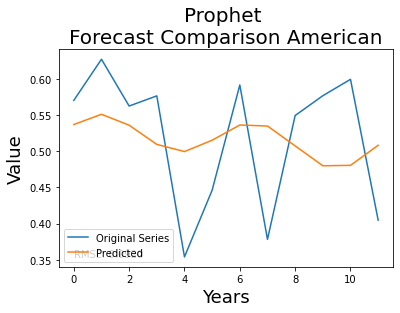

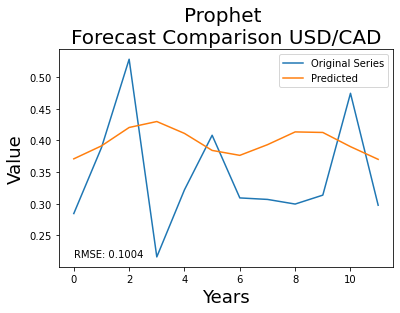

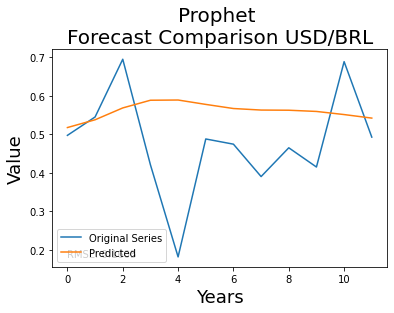


American Forecast Errors
  Error     Value
0    ME -0.003434
1   MAE  0.072541
2  RMSE  0.091984

USD/CAD Forecast Errors
  Error     Value
0    ME  0.051350
1   MAE  0.086580
2  RMSE  0.100353

USD/BRL Forecast Errors
  Error     Value
0    ME  0.080957
1   MAE  0.112086
2  RMSE  0.160530


In [37]:
#Create a new data frame only with the dates fir which we want to forecast 
future_american = pd.DataFrame(data=american_test.ds,columns=['ds'])
future_USD_CAD = pd.DataFrame(data=USD_CAD_test.ds,columns=['ds'])
future_USD_BRL = pd.DataFrame(data=USD_BRL_test.ds,columns=['ds'])

#Forecasting the future values
american_forecast = prophet_American.predict(future_american)
USD_CAD_forecast = prophet_USD_CAD.predict(future_USD_CAD)
USD_BRL_forecast = prophet_USD_BRL.predict(future_USD_BRL)

#This is needed just in order to have a decent plot, the indexes dont matter for the series, since we have the dates
american_test.index = american_forecast.index
USD_CAD_test.index = USD_CAD_forecast.index
USD_BRL_test.index = USD_BRL_forecast.index

plot_2_series(real=american_test.y,
            model=american_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_test.y,american_forecast.yhat)),
            title='Prophet \nForecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_test.y,
            model=USD_CAD_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_test.y,USD_CAD_forecast.yhat)),
            title='Prophet \nForecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_test.y,
            model=USD_BRL_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_test.y,USD_BRL_forecast.yhat)),
            title='Prophet \nForecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican Forecast Errors")
print(errors(american_test.y,american_forecast.yhat))
print("\nUSD/CAD Forecast Errors")
print(errors(USD_CAD_test.y,USD_CAD_forecast.yhat))
print("\nUSD/BRL Forecast Errors")
print(errors(USD_BRL_test.y,USD_BRL_forecast.yhat))

---------------------------------------------------------------------------------------------------------------------------------
## Non-Stationary Series

We must make an observation: a reason for implementing the models on differentiated series was, not only to compare with ARIMA, but also because it is more useful to model *stock return* series than stock prices themselves. By differentiating the series we get, precisely, the returns.

With that being said, the goal to model with non-stationary series is to study each model capacity to forecast that type of time series. One could say that the goal is to check if those models accpet more general forms of time series than ARIMA and GARCH models that are implemented only in stationary ones. 

The process from now on will be **exactly** the same, so comments won't be made unless necessary, since everything is already explained in the previous part.

## Training and Test Sets

In [52]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

# #normalizing the series
USD_CAD_serie = normalize(USD_CAD_serie)
USD_BRL_serie = normalize(USD_BRL_serie)
AmericanAirlines_serie = normalize(AmericanAirlines_serie)

print(AmericanAirlines_serie.head())
print(USD_CAD_serie.head())
print(USD_BRL_serie.head())

          ds         y
0 2010-01-01  0.022019
1 2010-01-08  0.028234
2 2010-01-15  0.025925
3 2010-01-22  0.020243
4 2010-01-29  0.026458
          ds         y
0 2010-01-01  0.174815
1 2010-01-08  0.153662
2 2010-01-15  0.207943
3 2010-01-22  0.238874
4 2010-01-29  0.250649
          ds         y
0 2010-01-01  0.041018
1 2010-01-08  0.046845
2 2010-01-15  0.055331
3 2010-01-22  0.070869
4 2010-01-29  0.073736


In [53]:
split = 12

american_train, american_test = train_test(AmericanAirlines_serie,split) 
USD_BRL_train, USD_BRL_test = train_test(USD_BRL_serie,split) 
USD_CAD_train, USD_CAD_test = train_test(USD_CAD_serie,split)


In [54]:
#Hyperparameters
changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale = [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']


import warnings
warnings.filterwarnings(action='ignore')


param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale,
    'seasonality_prior_scale': seasonality_prior_scale,
    'seasonality_mode': seasonality_mode,
    'holidays_prior_scale': holidays_prior_scale
}

#Since Prophet is not a Sklearn estimator, we will have to code the hyperparameter tunning by hand!
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

#Seaching for the best hyperparameter
rmses_american = hyperparameter_search(american_train,all_params)
rmses_USD_CAD = hyperparameter_search(USD_CAD_train,all_params)
rmses_USD_BRL = hyperparameter_search(USD_BRL_train,all_params)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [55]:
#Getting the best hyperparameter option
best_american = select_best_hyperparameters(rmses_american,all_params)
best_USD_CAD = select_best_hyperparameters(rmses_USD_CAD,all_params)
best_USD_BRL = select_best_hyperparameters(rmses_USD_BRL,all_params)

print("Best Hyperparameters American -> ",best_american)
print("Best Hyperparameters USD_CAD -> ",best_USD_CAD)
print("Best Hyperparameters USD_BRL -> ",best_USD_BRL)

Best Hyperparameters American ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}
Best Hyperparameters USD_CAD ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}
Best Hyperparameters USD_BRL ->  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


## Training the Prophet with the best hyperparameters

In [56]:
prophet_American = Prophet(**best_american).fit(american_train)

prophet_USD_CAD = Prophet(**best_USD_CAD).fit(USD_CAD_train)

prophet_USD_BRL = Prophet(**best_USD_BRL).fit(USD_BRL_train)                     

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

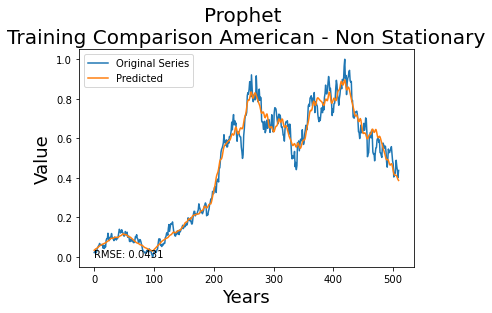

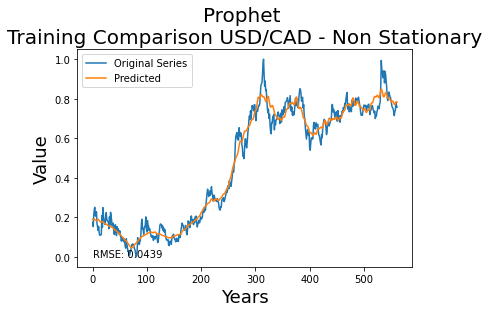

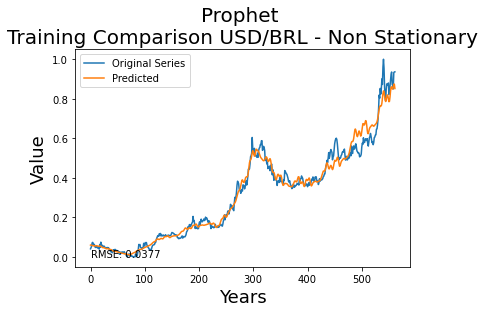


American Model Prediction Errors - Non Stationary
  Error     Value
0    ME -0.000111
1   MAE  0.023045
2  RMSE  0.043064

USD/CAD Model Prediction Errors - Non Stationary
  Error     Value
0    ME -0.000001
1   MAE  0.027834
2  RMSE  0.043950

USD/BRL Model Prediction Errors - Non Stationary
  Error     Value
0    ME -0.000182
1   MAE  0.018150
2  RMSE  0.037668


In [57]:
american_predicted = prophet_American.predict(american_train)
USD_CAD_predicted = prophet_USD_CAD.predict(USD_CAD_train)
USD_BRL_predicted = prophet_USD_BRL.predict(USD_BRL_train)

plot_2_series(real=american_train.y,
            model=american_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_train.y,american_predicted.yhat)),
            title='Prophet \nTraining Comparison American - Non Stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_train.y,
            model=USD_CAD_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_train.y,USD_CAD_predicted.yhat)),
            title='Prophet \nTraining Comparison USD/CAD - Non Stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_train.y,
            model=USD_BRL_predicted.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_train.y,USD_BRL_predicted.yhat)),
            title='Prophet \nTraining Comparison USD/BRL - Non Stationary',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors - Non Stationary")
print(errors(american_train.y,american_predicted.yhat))
print("\nUSD/CAD Model Prediction Errors - Non Stationary")
print(errors(USD_CAD_train.y,USD_CAD_predicted.yhat))
print("\nUSD/BRL Model Prediction Errors - Non Stationary")
print(errors(USD_BRL_train.y,USD_BRL_predicted.yhat))

## Forecast Comparison

In here we are forecasting only one step ahead, even though it may seem that the forecast horizon is 12.


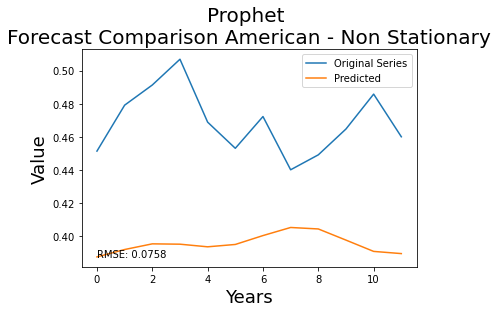

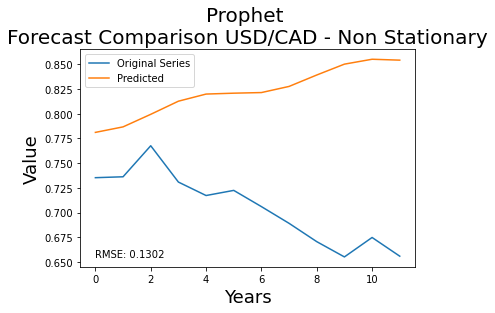

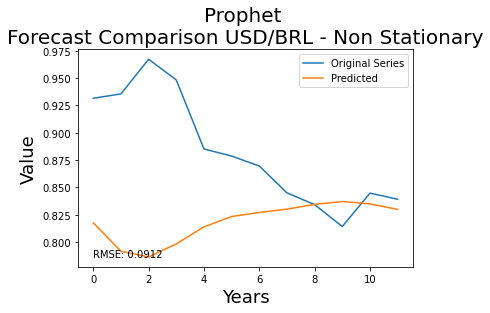


American Forecast Errors - Non Stationary
  Error     Value
0    ME -0.072873
1   MAE  0.071077
2  RMSE  0.075838

USD/CAD Forecast Errors - Non Stationary
  Error     Value
0    ME  0.117241
1   MAE  0.108994
2  RMSE  0.130164

USD/BRL Forecast Errors - Non Stationary
  Error     Value
0    ME -0.064058
1   MAE  0.048890
2  RMSE  0.091184


In [58]:
#Create a new data frame only with the dates fir which we want to forecast 
future_american = pd.DataFrame(data=american_test.ds,columns=['ds'])
future_USD_CAD = pd.DataFrame(data=USD_CAD_test.ds,columns=['ds'])
future_USD_BRL = pd.DataFrame(data=USD_BRL_test.ds,columns=['ds'])

#Forecasting the future values
american_forecast = prophet_American.predict(future_american)
USD_CAD_forecast = prophet_USD_CAD.predict(future_USD_CAD)
USD_BRL_forecast = prophet_USD_BRL.predict(future_USD_BRL)

#This is needed just in order to have a decent plot, the indexes dont matter for the series, since we have the dates
american_test.index = american_forecast.index
USD_CAD_test.index = USD_CAD_forecast.index
USD_BRL_test.index = USD_BRL_forecast.index

plot_2_series(real=american_test.y,
            model=american_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(american_test.y,american_forecast.yhat)),
            title='Prophet \nForecast Comparison American - Non Stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_test.y,
            model=USD_CAD_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_CAD_test.y,USD_CAD_forecast.yhat)),
            title='Prophet \nForecast Comparison USD/CAD - Non Stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_test.y,
            model=USD_BRL_forecast.yhat,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(USD_BRL_test.y,USD_BRL_forecast.yhat)),
            title='Prophet \nForecast Comparison USD/BRL - Non Stationary',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican Forecast Errors - Non Stationary")
print(errors(american_test.y,american_forecast.yhat))
print("\nUSD/CAD Forecast Errors - Non Stationary")
print(errors(USD_CAD_test.y,USD_CAD_forecast.yhat))
print("\nUSD/BRL Forecast Errors - Non Stationary")
print(errors(USD_BRL_test.y,USD_BRL_forecast.yhat))